[1] Dunis et al. (2005) 'Modelling and trading the gasoline crack spread: A non-linear story', Available at https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.568.7460&rep=rep1&type=pdf

[2] Engle, R. F. and Granger, C. W. J. (1987) 'Cointegration and Error Correction: Representation, Estimation and Testing', Available at https://doi.org/10.2307/1913236

[3] Enders, W. and Granger, C. (1998) 'Unit-root Tests and Asymmetric Adjustment with an Example Using the Term Structure of Interest Rates', Available at https://doi.org/10.2307/1392506

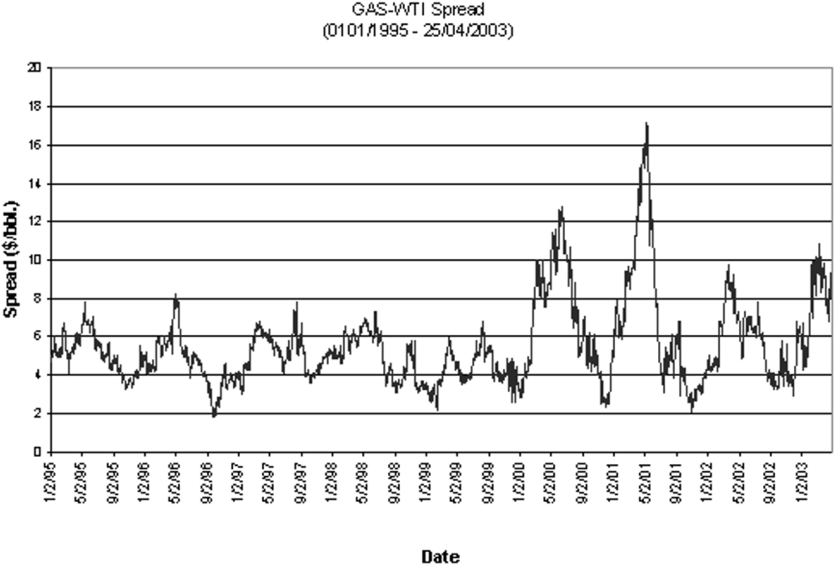

In [141]:
Image(filename='images/crack_spread.png')

# Abstract
In [1] the case is made that the crack spread exhibits asymmetry at the \\$5 dollar mark, with seemingly larger moves occuring on the upside of the long-term 'fair value' than on the downside.


The gasoline crack spread can be interpreted as the profit margin gained by processing crude oil into unleaded gasoline. It is simply the monetary difference between West Texas Intermediate crude oil and Unleaded Gasoline, both of which are traded on the New York Mercantile Exchange (NYMEX).

$$ S_{t} = GAS_t - WTI_t $$

$S_{t}$ is the price of the spread at time $t$ (in \\$ per barrel), $GAS_t$ is the price of unleaded gasoline at time $t$ (in \\$ per barrel), and $WTI_t$ is the price of West Texas Intermediate crude oil at time $t$ (in \\$ per
barrel).

## Non-linear cointegration

Cointegration was first introduced by Engle and Granger [2]. The technique is to test the null hypothesis that any combination of two series contains a unit root. If the null hypothesis is refuted and the conclusion is that a unit root does not exist, the combination of the two series is cointegrated. This is explained further below. 

As explained in the previous section, the spread may exhibit larger moves in one direction than in the other, this is known as asymmetry. Since the traditional unit root test has only one parameter for the autoregressive estimate, it assumes upside and downside moves to be identical or symmetric.

Non-linear cointegration was first introduced by Enders and Granger[3], who extended the unit root test by considering upside and downside moves separately, thus allowing for the possibility of asymmetric adjustment. 

In [166]:
from IPython.display import Image

import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.johansen import JohansenPortfolio

In [57]:
wti_gas_df = pd.read_csv('./data/wti_gas.csv').set_index('date')
wti_gas_df.index = pd.to_datetime(wti_gas_df.index) 
wti_gas_df

wti_gas_paper_df = wti_gas_df['1995-01': '2003-04']

In [96]:
wti_gas_paper_df

,wti,gasoline,dollar_spread,wti_rets,gasoline_rets,spread_rets
date,,,,,,
1995-01-03,17.44,22.176,-4.736,-0.018018,-0.055456,0.037438
1995-01-04,17.48,22.428,-4.948,0.002294,0.011364,-0.009070
1995-01-05,17.72,22.890,-5.170,0.013730,0.020599,-0.006869
1995-01-06,17.67,22.596,-4.926,-0.002822,-0.012844,0.010022
1995-01-09,17.40,22.638,-5.238,-0.015280,0.001859,-0.017139
...,...,...,...,...,...,...
2003-04-24,26.64,36.918,-10.278,-0.000375,0.036557,-0.036932
2003-04-25,26.26,37.128,-10.868,-0.014264,0.005688,-0.019953
2003-04-28,25.49,35.364,-9.874,-0.029322,-0.047511,0.018189


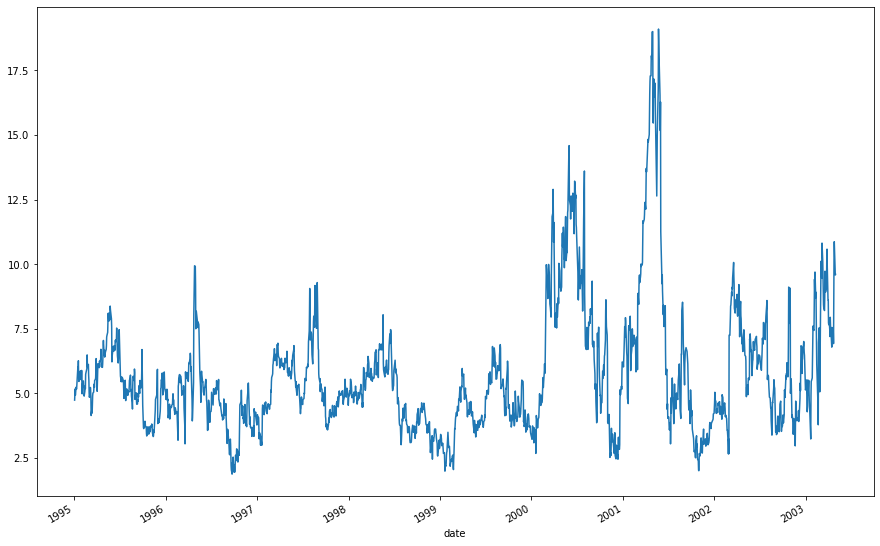

In [146]:
(wti_gas_paper_df['gasoline'] - wti_gas_paper_df['wti']).plot(figsize=(15,10))

Enders and Granger extend the Dickey-Fuller test to allow for the unit root hypothesis to be tested against an
alternative of asymmetric adjustment. Here, this is developed from its simplest form; consider the standard Dickey–Fuller test

$$ \Delta \mu_{t} = p \mu_{t-1} + \epsilon_t $$ 

where $\epsilon_t$ is a white noise process. The null hypothesis of $p=0$ is tested against the alternative of $p \neq 0 $. $p=0$ indicates that there is no unit root, and therefore $\mu_i$ is a stationary series. If the series $\mu_i$ are the residuals of a long-run cointegration relationship as indicated by Johansen, this
simply results in a test of the validity of the cointegrating vector (the residuals of the cointegration equation should form a stationary series).

The extension provided by Enders and Granger is to consider the upside and downside moves separately, thus allowing for the possibility of asymmetric adjustment. Following this approach;

$$ \Delta \mu_{t} = I_t p_1 \mu_{i-1} + (1 - I_t) p_2 \mu_{i-1} + \epsilon_t  $$

where $I_t$ is the zero-one ‘heaviside’ indicator function. This paper uses the following specification;

$$ I_t = \left \{ {{1, if \mu_{t-1} \geq 0} \over {0, if \mu_{t-1} < 0}} \right. $$

Enders and Granger refer to the model defined above as threshold autoregressive (TAR). The null hypothesis of symmetric adjustment is $(H_0: p_1 = p_2)$, which can be tested using the standard F-test (in this case
the Wald test), with an additional requirement that both $p_1$ and $p_2$ do not equal zero. If $p_1 \neq p_2$, cointegration between the underlying assets is non-linear.

In this case a trading model as described in Evans et al. 6 will be misspecified and equation (4) should be used to predict $\Delta \mu_t$. 

A fair value trading model has been developed from this procedure. In this model, equation (4) is used to estimate
values of $\Delta \mu_t$ from values of $\mu_{t–1}$. The values of $p_1$ and $p_2$ are estimated for the in-sample period and fixed for the out-of-sample period.

In [228]:
class TAR(JohansenPortfolio):
    
    def __init__(self, price_data: pd.DataFrame):
        super().fit(price_data)
        self.spread = super().construct_mean_reverting_portfolio(price_data)

    def _tag_regime(self, series: pd.Series) -> pd.DataFrame:
        tagged_df = series.copy().to_frame()
        tagged_df.columns = ['y_{t-1}']
        tagged_df['I_{1}'] = 0
        tagged_df['I_{0}'] = 0
        tagged_df.loc[tagged_df['y_{t-1}'] >= 0, 'I_{1}'] = 1
        tagged_df.loc[tagged_df['y_{t-1}'] < 0, 'I_{0}'] = 1
        return tagged_df.dropna()
    
    def fit(self):
        
        """
        
        :param Y: (pd.Series) Vector of Changes in Spread.
        :param X: (pd.Series) Vector of Dollar Spread lagged by 1.
        """
        jspread = pd.DataFrame(self.spread) 
        jspread.columns = ['spread']
        jspread['rets'] = jspread['spread'].diff() 
        jspread['spread_lag1'] = jspread['spread'].shift(1) 
        jspread.dropna(inplace=True)
        
        Y = jspread['rets']
        
        X = jspread['spread_lag1']
        
        tagged_Y = self._tag_regime(X)  

        regime_one = tagged_Y['y_{t-1}'] * tagged_Y['I_{1}']
        regime_two = tagged_Y['y_{t-1}'] * tagged_Y['I_{0}']
        
        regime_X = pd.concat([regime_one, regime_two], axis=1)

        regime_X.columns = ['p_1', 'p_2']

        model = sm.OLS(Y.values, regime_X)
        results = model.fit()
        return results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              16.19
Date:                Thu, 19 Nov 2020   Prob (F-statistic):                    1.05e-07
Time:                        15:10:45   Log-Likelihood:                         -11.084
No. Observations:                2082   AIC:                                      26.17
Df Residuals:                    2080   BIC:                                      37.45
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
p_1           -0.0214      0.006     -3.706      0.000      -0.033      -0.010
p_2           -0.0477      0.011     -4.318      0.000      -0.069      -0.026
==============================================================================
Omnibus:                      438.740   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15671.723
Skew:                          -0.065   Prob(JB):                         0.00
Kurtosis:                      16.440   Cond. No.                         1.92
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

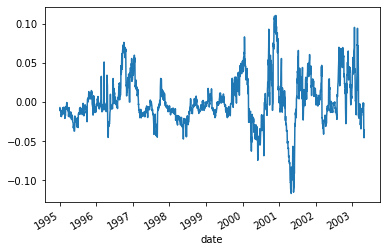

In [229]:
tar_results = TAR(wti_gas_paper_df[['gasoline', 'wti']]).fit()

tar_results.fittedvalues.plot()

tar_results.summary()

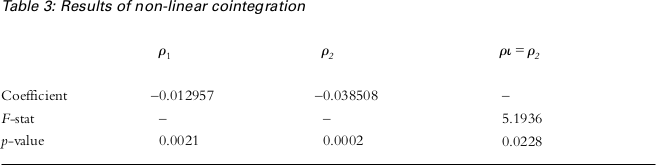

In [169]:
Image(filename='images/paper_results.png')

In [216]:
def get_results_as_paper_table(tar_results):

    coefficient_1 = tar_results.params.loc['p_1']
    pvalue_1 = tar_results.wald_test('p_1 = 0').pvalue


    coefficient_2 = tar_results.params.loc['p_2']
    pvalue_2 = tar_results.wald_test('p_2 = 0').pvalue

    equiv_fvalue = tar_results.wald_test('p_1 = p_2').fvalue
    equiv_pvalue = tar_results.wald_test('p_1 = p_2').pvalue


    tuple_frame = [(coefficient_1, None, pvalue_1), 
                   (coefficient_2, None, pvalue_2),
                   (None, equiv_fvalue[0][0], equiv_pvalue)]

    result_frame = pd.DataFrame(tuple_frame).T
    result_frame.columns = ['p_1', 'p_2', 'p_1 = p_2']
    result_frame['index'] = ['Coefficient', 'F-stat', 'p-value']
    result_frame.set_index('index', inplace=True)
    return result_frame.astype(float)

In [217]:
get_results_as_paper_table(tar_results)

,p_1,p_2,p_1 = p_2
index,,,
Coefficient,-0.021441,-0.047393,NaN
F-stat,NaN,NaN,4.371485
p-value,0.000213,0.000017,0.036666


In [240]:
tar_results.fittedvalues.to_csv('./data/tar_residual_gas_wti.csv')